[View in Colaboratory](https://colab.research.google.com/github/connected-bsamadi/colab-notebooks/blob/master/Package_Recommendation_Engine_Multilabel_Classification.ipynb)

# Setting up

In [0]:
# Google Cloud authentication
from google.colab import auth
auth.authenticate_user()

In [0]:
from google.cloud import bigquery
from google.colab import files
import json
import re
import random
import pandas as pd
import pandas_gbq
import sys
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [0]:
# Assigning the project name and creating the BigQuery client
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'ontario-2018'
client = bigquery.Client(project=project_id)

# Data Query
BigQuery is used to get the data from the github_repos dataset.

## Extracting packages

In [5]:
### Get packages from BigQuery
# Original query costs $15
query = r'''
SELECT
  files.repo_name,
  contents.content
FROM
  `bigquery-public-data.github_repos.contents` contents
JOIN
  `bigquery-public-data.github_repos.files` files
ON
  contents.id = files.id
JOIN
  `bigquery-public-data.github_repos.sample_repos` most_watched
ON
  most_watched.repo_name = files.repo_name
WHERE
  files.path = 'package.json'
LIMIT
  100000
'''
# Using the saved results
query = r'SELECT * FROM `ontario-2018.github.most_watched_packages_100k`'
# Query the dataset
query_job = client.query(query)
package_df = query_job.to_dataframe()
package_df.shape

(37962, 2)

In [6]:
package_df.head()

,repo_name,content
0,lsphillips/Crumble,"{\n\t""name"" : ""crumble"",\n\n\t""version"" : ""2.0..."
1,DawidMyslak/corkdev-angular2-examples,"{\n ""name"": ""corkdev-angular2-examples"",\n ""..."
2,mstefaniuk/graph-viz-d3-js,"{\n ""name"": ""graphviz-d3-renderer"",\n ""versi..."
3,observing/balancerbattle,"{\n ""name"": ""balancerbattle"",\n ""version"": ""..."
4,veeracs/SniffAdBlock,"{\n ""name"": ""SniffAdBlock"",\n ""version"":..."


In [0]:
# A function to extract name, devDependencies, dependencies and keywords from content
def get_pkg(package_json):
    package_record = {}
    try:
      repo_obj = json.loads(package_json)
      if 'name' in repo_obj:
        package_record['name'] = repo_obj['name']
      if 'devDependencies' in repo_obj:
        dev_dependencies = repo_obj['devDependencies']
        if (len(dev_dependencies) > 0):
          package_record['devDependencies'] = dev_dependencies
      if 'dependencies' in repo_obj:
        dependencies = repo_obj['dependencies']
        if (len(dependencies) > 0):
          package_record['dependencies'] = dependencies
      if 'keywords' in repo_obj:
        keywords = repo_obj['keywords']
        if (len(keywords) > 0):
          package_record['keywords'] = keywords
    finally:
      return package_record

In [8]:
# Extracting devDependencies, dependencies and keywords from package.json
package_df.columns = ['repo_name','package_info']
package_df['package_info']=package_df['package_info'].apply(get_pkg)
package_df.head()

,repo_name,package_info
0,lsphillips/Crumble,"{'name': 'crumble', 'devDependencies': {'mocha..."
1,DawidMyslak/corkdev-angular2-examples,"{'name': 'corkdev-angular2-examples', 'devDepe..."
2,mstefaniuk/graph-viz-d3-js,"{'name': 'graphviz-d3-renderer', 'devDependenc..."
3,observing/balancerbattle,"{'name': 'balancerbattle', 'dependencies': {'w..."
4,veeracs/SniffAdBlock,"{'name': 'SniffAdBlock', 'keywords': ['ad', 'b..."


## Extracting Readme Files

In [9]:
# Get README.md files from dataset
# Original query costs $15
query = r'''
SELECT
  files.repo_name,
  contents.content
FROM
  `bigquery-public-data.github_repos.contents` contents
INNER JOIN
  `bigquery-public-data.github_repos.files` files
ON
  contents.id = files.id
JOIN
  `ontario-2018.github.most_watched_packages_100k` packages
ON
  packages.repo_name = files.repo_name
WHERE
  files.path IN ('readme.md',
    'Readme.md',
    'README.md',
    'README.MD')
'''
# Using the saved results
query = r'SELECT * FROM `ontario-2018.github.most_watched_readme_100k`'
query_job = client.query(query)
readme_df = query_job.to_dataframe()
readme_df.columns = ['repo_name','readme']
readme_df.head()

,repo_name,readme
0,williamngan/line,# Taking a Line for a Walk\n\n![a drawing gif]...
1,nikkiii/backupd,# BackupD\n\nA simple backup http server to st...
2,hitmands/angular-hitmands-auth,# Angular Hitmands Auth\n[![Build Status](http...
3,Knorcedger/generator-knr-generator,# generator-knr-generator [![Build Status](htt...
4,JedWatson/keystone-forum,KeystoneJS Forums\n===============\n\nAbandone...


In [10]:
repos = readme_df["repo_name"]
# Number of repositories
len(repos)

37226

## Joining the data frames of packages and README files

In [11]:
data=pd.merge(readme_df,package_df,how='inner')
data.head()

,repo_name,readme,package_info
0,williamngan/line,# Taking a Line for a Walk\n\n![a drawing gif]...,"{'name': 'psychogeometry', 'devDependencies': ..."
1,nikkiii/backupd,# BackupD\n\nA simple backup http server to st...,"{'name': 'backupd', 'dependencies': {'basic-au..."
2,hitmands/angular-hitmands-auth,# Angular Hitmands Auth\n[![Build Status](http...,"{'name': 'angular-hitmands-auth', 'devDependen..."
3,Knorcedger/generator-knr-generator,# generator-knr-generator [![Build Status](htt...,"{'name': 'generator-knr-generator', 'devDepend..."
4,JedWatson/keystone-forum,KeystoneJS Forums\n===============\n\nAbandone...,"{'name': 'keystone-forum', 'dependencies': {'a..."


In [12]:
data.shape

(37226, 3)

## Listing the packages in all the repositories

In [0]:
def collect_pkg(pckg_info):
  packages_dic = list([])
  if 'devDependencies' in pckg_info:
    packages_dic = packages_dic+list(pckg_info['devDependencies'])
  if 'dependencies' in pckg_info:
    packages_dic = packages_dic+list(pckg_info['dependencies'])
  return packages_dic

In [14]:
data['package_info']=data['package_info'].apply(collect_pkg)
data.head()

,repo_name,readme,package_info
0,williamngan/line,# Taking a Line for a Walk\n\n![a drawing gif]...,"[event-stream, gulp, gulp-util, gulp-concat, g..."
1,nikkiii/backupd,# BackupD\n\nA simple backup http server to st...,"[basic-auth, clouddrive, events-intercept, exp..."
2,hitmands/angular-hitmands-auth,# Angular Hitmands Auth\n[![Build Status](http...,"[karma, karma-jasmine, codeclimate-test-report..."
3,Knorcedger/generator-knr-generator,# generator-knr-generator [![Build Status](htt...,"[eslint, eslint-config-google, generator-angul..."
4,JedWatson/keystone-forum,KeystoneJS Forums\n===============\n\nAbandone...,"[async, dotenv, keystone, moment, moment-timez..."


In [0]:
# Function for counting the number of package usages
def count_pkg(package_info):
  c = Counter()
  for pkglist in package_info:
    for package in pkglist:
      if isinstance(package, str):
        c[package] += 1
  return c

In [16]:
# Make a dataframe for packages and their number of usages
pkg_usage = count_pkg(data['package_info'])

pkg_data = {}
pkg_data['count']=list(pkg_usage.values())
pkg_data['package']=list(pkg_usage.keys())

pkg_df=pd.DataFrame(data=pkg_data)[['package','count']]
pkg_df=pkg_df.sort_values(by=['count'],ascending=False)
pkg_df.index=range(pkg_df.shape[0])
pkg_df.head()

,package,count
0,mocha,9778
1,eslint,6183
2,gulp,5688
3,chai,5369
4,grunt,5305


In [17]:
pkg_df.shape

(38108, 2)

### Selecting specific packages

In [18]:
# Removing packages with fewer than 100 usages
pkg_df=pkg_df.drop([i for i in pkg_df.index if pkg_df['count'][i]<100])
pkg_df.shape

(689, 2)

In [0]:
all_packages = list(pkg_df['package'])

In [0]:
# Selecting "interesting" packages from the table in https://www.javascripting.com/
packages = {p for p in all_packages if p.find('react') >= 0 or
                                       p.find('vue') >= 0 or
                                       p.find('angular') >= 0 or
                                       p.find('axios') >= 0 or
                                       p.find('three') >= 0 or
                                       p.find('moment') >= 0 or 
                                       p.find('leaflet') >= 0 or
                                       p.find('video') >= 0 or
                                       p.find('jquery') >= 0 or
                                       p.find('material') >= 0 or
                                       p.find('express') >= 0 or
                                       p.find('electron') >= 0 or
                                       p.find('d3') >= 0
           }

In [21]:
# Target packages
n_packages=len(packages)
n_packages

60

In [0]:
def filter_pkg(pkg_info):
  return [pkg for pkg in pkg_info if pkg in packages]

In [23]:
# Remove other packages
data['package_info'] = data['package_info'].apply(filter_pkg)
data.head()
  

,repo_name,readme,package_info
0,williamngan/line,# Taking a Line for a Walk\n\n![a drawing gif]...,[]
1,nikkiii/backupd,# BackupD\n\nA simple backup http server to st...,"[express, moment]"
2,hitmands/angular-hitmands-auth,# Angular Hitmands Auth\n[![Build Status](http...,"[express, grunt-angular-templates]"
3,Knorcedger/generator-knr-generator,# generator-knr-generator [![Build Status](htt...,[]
4,JedWatson/keystone-forum,KeystoneJS Forums\n===============\n\nAbandone...,"[moment, moment-timezone]"


In [24]:
# Remove repos with empty packages
data = data.drop([i for i in data.index if len(data['package_info'][i])==0])
data.head()

,repo_name,readme,package_info
1,nikkiii/backupd,# BackupD\n\nA simple backup http server to st...,"[express, moment]"
2,hitmands/angular-hitmands-auth,# Angular Hitmands Auth\n[![Build Status](http...,"[express, grunt-angular-templates]"
4,JedWatson/keystone-forum,KeystoneJS Forums\n===============\n\nAbandone...,"[moment, moment-timezone]"
5,MarkUsProject/Markus,![MarkUs logo](http://markusproject.org/img/ma...,"[babel-preset-react, react, react-dom]"
6,gre/bezier-easing-editor,bezier-easing-editor\n====================\nCu...,[babel-preset-react]


### Removing empty readme files

In [25]:
# Remove repos with empty readme files
data['readme']=data['readme'].fillna('')
data = data.drop([i for i in data.index if data['readme'][i] == ''])
data.head()

,repo_name,readme,package_info
1,nikkiii/backupd,# BackupD\n\nA simple backup http server to st...,"[express, moment]"
2,hitmands/angular-hitmands-auth,# Angular Hitmands Auth\n[![Build Status](http...,"[express, grunt-angular-templates]"
4,JedWatson/keystone-forum,KeystoneJS Forums\n===============\n\nAbandone...,"[moment, moment-timezone]"
5,MarkUsProject/Markus,![MarkUs logo](http://markusproject.org/img/ma...,"[babel-preset-react, react, react-dom]"
6,gre/bezier-easing-editor,bezier-easing-editor\n====================\nCu...,[babel-preset-react]


In [26]:
data.shape

(10989, 3)

### Export to CSV

In [27]:
dataset=data.loc[data.index,['readme','package_info']]
dataset.head()

,readme,package_info
1,# BackupD\n\nA simple backup http server to st...,"[express, moment]"
2,# Angular Hitmands Auth\n[![Build Status](http...,"[express, grunt-angular-templates]"
4,KeystoneJS Forums\n===============\n\nAbandone...,"[moment, moment-timezone]"
5,![MarkUs logo](http://markusproject.org/img/ma...,"[babel-preset-react, react, react-dom]"
6,bezier-easing-editor\n====================\nCu...,[babel-preset-react]


In [0]:
# Return lst[n] if it exists
def selectn(lst,n):
  if len(lst) > n:
    return lst[n]
  else:
    return None

In [29]:
# Maximum number of packages
max_n_pkg = max(dataset['package_info'].apply(len))
max_n_pkg

21

In [0]:
# Create new columns for labels
for i in range(max_n_pkg): 
  dataset['label'+str(i)]=dataset['package_info'].apply(selectn,args={i})

In [0]:
# Remove the package_info column
dataset=dataset.drop('package_info',axis=1)

In [0]:
# Remove newline characters
def remove_newline(txt):
  txt_maxlen = 10000-2
  if len(txt) > txt_maxlen:
    qtxt = txt[0:txt_maxlen]
  else:
    qtxt = txt
  qtxt = '\"'+qtxt.replace('\"',' ')+'\"'
  qtxt = qtxt.replace('\r',' ')
  qtxt = qtxt.replace('\n',' ')
  qtxt = qtxt.replace('\t',' ')
  qtxt = qtxt.replace('#',' ')
  return qtxt

In [33]:
dataset["readme"]=data["readme"].apply(remove_newline)
dataset.head()

,readme,label0,label1,label2,label3,label4,label5,label6,label7,label8,...,label11,label12,label13,label14,label15,label16,label17,label18,label19,label20
1,""" BackupD A simple backup http server to sto...",express,moment,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,""" Angular Hitmands Auth [![Build Status](http...",express,grunt-angular-templates,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,"""KeystoneJS Forums =============== Abandoned....",moment,moment-timezone,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,"""![MarkUs logo](http://markusproject.org/img/m...",babel-preset-react,react,react-dom,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,"""bezier-easing-editor ==================== Cub...",babel-preset-react,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [34]:
dataset.shape

(10989, 22)

In [0]:
# Write the dataset into a file
dataset.to_csv('githubreadmepackage.csv',index=False,header=False)

In [0]:
input_file = open('githubreadmepackage.csv')
output_file = open('github_readme_package.csv','wt')

In [0]:
def clean_line(line):
  txt = line
  pattern = re.compile(r'(,){2,}')
  txt = re.sub(pattern, ' ', txt)
  pattern = re.compile(r'( ){2,}')
  txt = re.sub(pattern, ' ', txt)
  pattern = re.compile(r'("){3}')
  txt = re.sub(pattern, r'"', txt)
  return txt

In [0]:
for line in input_file:
  cline = clean_line(line)
  if not cline.startswith('\" \",', 0, 4):
    output_file.write(cline)

In [0]:
files.download('github_readme_package.csv')

# Training data

In [0]:
# One-hot encoding of packages in repos
n_repos=data.shape[0]
n_pkgs=len(packages)
y = np.zeros((n_repos,n_pkgs))
for n_repo, i in zip(range(len(data.index)),data.index):
  for n_pkg, pkg in zip(range(len(packages)),packages):
    if pkg in data['package_info'][i]:
      y[n_repo,n_pkg] = 1

In [0]:
readme_train=data["readme"]
max_features = 1000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(readme_train))
readme_tokenized_train = tokenizer.texts_to_sequences(readme_train)

In [42]:
dir(tokenizer)
print(tokenizer.word_counts)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
maxlen = 500
X_t = pad_sequences(readme_tokenized_train, maxlen=maxlen)

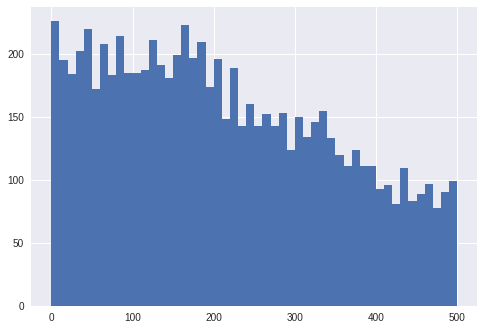

In [44]:
totalNumWords = [len(readme) for readme in readme_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,maxlen+10,10))
plt.show()

# Bag of Words Model

## Building the model

In [0]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(maxlen,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512, input_shape=(maxlen,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_packages))
model.add(Activation('sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               256512    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 60)                30780     
__________

## Training

In [47]:
batch_size = 32
epochs = 20
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 9890 samples, validate on 1099 samples
Epoch 1/20
9890/9890 [==============================] - 5s 518us/step - loss: 0.0686 - acc: 0.1798 - val_loss: 0.0544 - val_acc: 0.2011
Epoch 2/20
9890/9890 [==============================] - 5s 460us/step - loss: 0.0515 - acc: 0.2110 - val_loss: 0.0543 - val_acc: 0.2011
Epoch 3/20
9890/9890 [==============================] - 5s 471us/step - loss: 0.0513 - acc: 0.2124 - val_loss: 0.0543 - val_acc: 0.2011
Epoch 4/20
9890/9890 [==============================] - 5s 461us/step - loss: 0.0513 - acc: 0.2126 - val_loss: 0.0543 - val_acc: 0.2011
Epoch 5/20
9890/9890 [==============================] - 5s 468us/step - loss: 0.0514 - acc: 0.2117 - val_loss: 0.0543 - val_acc: 0.2011
Epoch 6/20
9890/9890 [==============================] - 5s 464us/step - loss: 0.0513 - acc: 0.2123 - val_loss: 0.0543 - val_acc: 0.2011
Epoch 7/20
9890/9890 [==============================] - 5s 467us/step - loss: 0.0513 - acc: 0.2121 - val_loss: 0.0543 - val_acc: 0.2011


## Evaluation

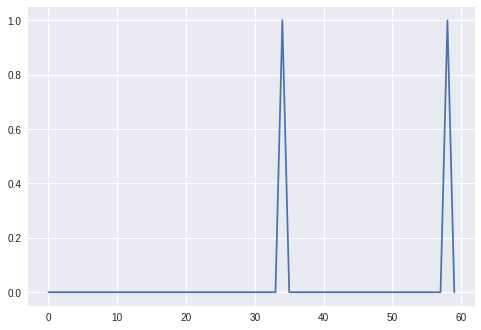

In [48]:
n_t=1
x_tst=np.reshape(X_t[n_t,:],(1,maxlen))
plt.plot(y[n_t,:])

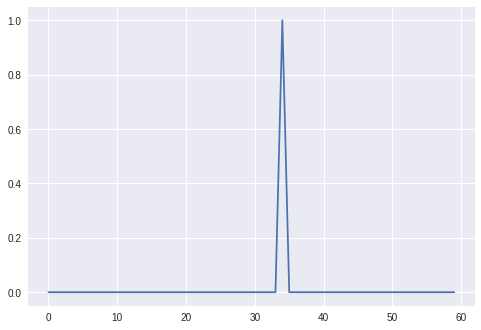

In [49]:
y_p = model.predict(x_tst, verbose=0)[0]
plt.plot(y_p)

## Prediction